#Vika Valencia Susanto - 2440062123
**CASE2 - RoBERTa**
Link video: https://drive.google.com/file/d/1fD7lEEl5yeBH4fQ0rif95zpVJOtXlSLi/view?usp=share_link 
RoBERTa (A Robustly Optimized Bert Pretraining Aproach) merupakan modifikasi dari model BERT dengan memodifikasi hyperparameternya, menghilangkan objektif pre-training kalimat selanjutnya dan memungkinkan untuk training dengan mini-batch yang lebih besar dan learning rates.Singkatnya, ia merupakan model transformer berbasis bahasa yang menggunakan self-attention untuk memproses sequence input dan menghasilkan representasi kata yang dikontekskan dalam sebuah kalimat.

Arsitekturnya sama dengan BERT tetapi menggunakan tokenizer level BPE byte dan menggunakan skema pre-training sang berbeda.

Referensi: https://arxiv.org/pdf/1907.11692v1.pdf 

In [1]:
import pandas as pd #untuk analisis dan manipulasi data
import matplotlib.pyplot as plt #untuk visualisasi data
import seaborn as sns #high-level visualization
import re #untuk pre-process string

In [2]:
import nltk #berisi koleksi library untuk NLP
nltk.download('stopwords') #stopwords (seperti is, the) merupakan kata yang tidak berarti untuk sebuah kalimat
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

# !pip install tensorflow==2.7
import tensorflow as tf
from tensorflow import keras

#metrics untuk evaluasi model
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
!pip install transformers
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# DATASET

In [4]:
df_data = pd.read_csv("dataset.csv")
df_data.head()

,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,predicted_category,sentiment
0,326d4bdd-8fc6-4d64-b3bf-ce393fb2ae9b,woww,5,0,NaN,2022-08-16 05:55:38,NaN,NaN,USER_EXPERIENCE,NEUTRAL
1,4bbf741b-2f69-43cd-bb76-f9b5f84c83b5,let me know more details about this,3,0,4.5.1143533,2022-08-16 04:44:45,NaN,NaN,CONTENT,NEUTRAL
2,3cb1136d-e7c6-4999-aa84-fdc7bcdccf56,i've been using this for a while and there's a...,2,0,4.5.1143533,2022-08-16 04:05:27,NaN,NaN,INTERFACE,NEGATIVE
3,d6f80f05-a6e8-44f3-a380-7c59ed3d208b,good,2,0,4.5.1143533,2022-08-16 00:22:33,NaN,NaN,USER_EXPERIENCE,POSITIVE
4,eecb277c-c658-4b2d-86c9-77d3a7022cac,mjkobe,5,0,4.5.1143533,2022-08-15 20:08:25,NaN,NaN,USER_EXPERIENCE,NEUTRAL


In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45414 entries, 0 to 45413
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              45414 non-null  object
 1   content               45414 non-null  object
 2   score                 45414 non-null  int64 
 3   thumbsUpCount         45414 non-null  int64 
 4   reviewCreatedVersion  40367 non-null  object
 5   at                    45414 non-null  object
 6   replyContent          2477 non-null   object
 7   repliedAt             2477 non-null   object
 8   predicted_category    45414 non-null  object
 9   sentiment             45414 non-null  object
dtypes: int64(2), object(8)
memory usage: 3.5+ MB


Dataset merupakan data review di medium yang berisikan 45414 data dengan 10 variabel. Variabel yang akan digunakan untuk melakukan sentiment analysis adalah content (isi reviewnya) dan sentiment (hasil sentimentnya). Sedangkan, jumlah data yang akan diambil hanya sebesar 50% dari data, karena waktu training yang cukup lama dan sistem akan masuk ke OOM (Out of Memory) dan laptop saya ngecrash mengingat model roBERTa memiliki 124 juta trainable parameter. Saya sudah mencoba dengan menggunakan jupyter (lagging yang sangat parah dan berefek ke satu laptop kemudian laptop akan crash dan restart ulang) dan google collab (ram full).

- 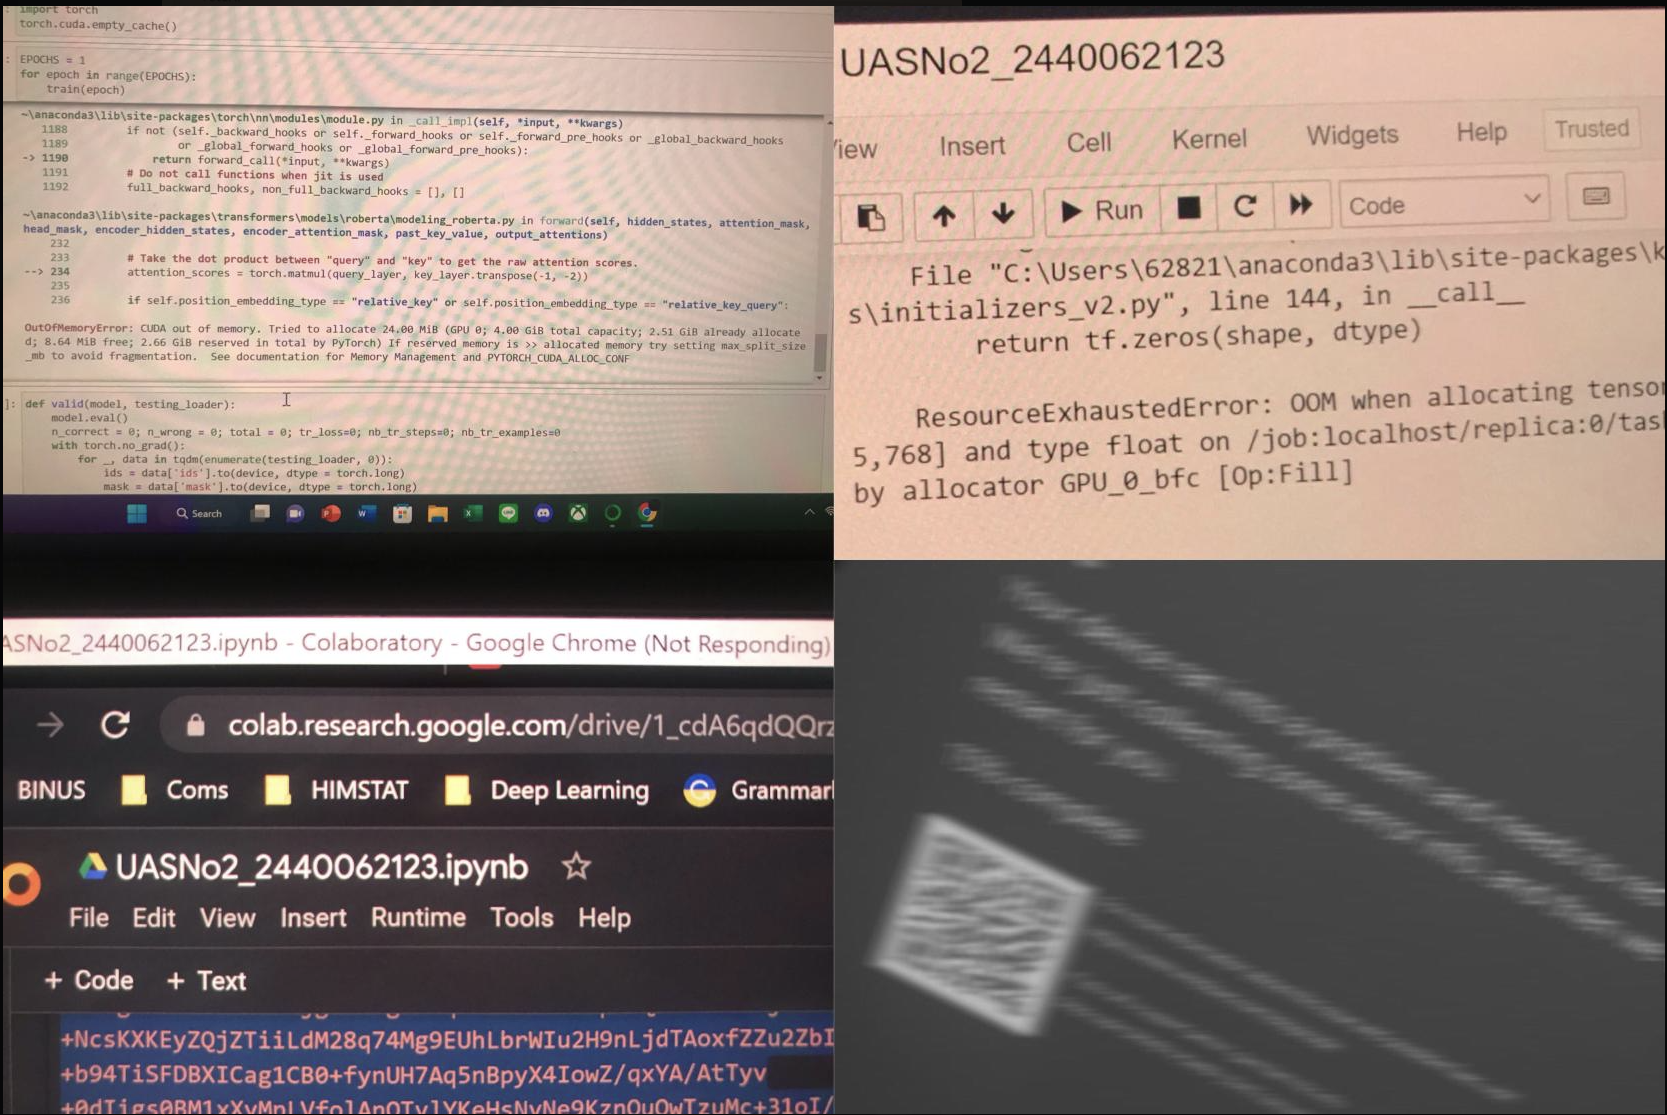

In [6]:
# data = df_data.sample(frac=0.05,random_state=42)
data = df_data[['content','sentiment']]
data.head()

,content,sentiment
0,woww,NEUTRAL
1,let me know more details about this,NEUTRAL
2,i've been using this for a while and there's a...,NEGATIVE
3,good,POSITIVE
4,mjkobe,NEUTRAL


In [7]:
data.sentiment.value_counts()

POSITIVE    34281
NEUTRAL      5889
NEGATIVE     5244
Name: sentiment, dtype: int64

Data baru dibuat dengan berisikan 'content' dan 'sentiment' saja. Pada variabel sentiment terdapat 3 kategori sentimen yang akan diprediksi yaitu POSITIVE, NEUTRAL, dan NEGATIVE.

# PREPROCESSING DATA

In [8]:
lm = WordNetLemmatizer()
def preprocessing(data_col):
  context = []
  for item in data_col:
    new_item = re.sub('[^a-zA-Z]',' ',str(item))
    new_item = new_item.lower()
    new_item = new_item.split()
    new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
    context.append(' '.join(str(x) for x in new_item))
  return context

Pre-processing data dilakukan dengan 4 cara:
Pertama iterasi dulu semua datanya dengan loop for
1. Hilangkan karakter diluar alfabet
2. Konversi semua string ke huruf kecil agar tidak terjadi duplikasi data nantinya karena sistem mendeteksi kata dengan perbedaan huruf kapital dan kecil itu berbeda. Misal 'Kata' dan 'kata' merupakan kata yang berbeda.

Kemudian kalimat akan dipisah per kata
3. Lematisasi setiap kata yang tidak mengandung stopword sehingga stopword akan dibuang, contoh lematitasi adalah dari bentuk verb past tense, future tense, akan di konversi ke verb awal (ex: eating, eats, dan ate akan menjadi eat)

Gabungkan semua kata tadi menjadi sebuah kalimat kembali

Referensi: https://www.analyticsvidhya.com/blog/2021/06/nlp-sentiment-analysis/ 

In [9]:
data['content'] = preprocessing(data['content'])
data.head()

<ipython-input-9-3377594bedf0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['content'] = preprocessing(data['content'])


,content,sentiment
0,woww,NEUTRAL
1,let know detail,NEUTRAL
2,using basic bug still fixed scrolling article ...,NEGATIVE
3,good,POSITIVE
4,mjkobe,NEUTRAL


Data yang akan dipre-processing adalah variabel content, sehingga hasil akhirnya ditampilkan pada tabel di atas

In [10]:
!pip install langdetect
from langdetect import detect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
data['low'] = data['content'].str.lower()
data2 = data[data['low'].str.islower()]

data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45266 entries, 0 to 45413
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    45266 non-null  object
 1   sentiment  45266 non-null  object
 2   low        45266 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


<ipython-input-11-85dae9097e2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['low'] = data['content'].str.lower()


In [12]:
data2['bahasa'] = data2['content'].apply(detect)
final_data = data2[data2['bahasa']=='en']

<ipython-input-12-89a05fea0cf2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['bahasa'] = data2['content'].apply(detect)


In [13]:
final_data.head()
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29615 entries, 1 to 45413
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    29615 non-null  object
 1   sentiment  29615 non-null  object
 2   low        29615 non-null  object
 3   bahasa     29615 non-null  object
dtypes: object(4)
memory usage: 1.1+ MB


Data2 merupakan data yang brisikan semua kalimat yang sudah berhuruf kecil. Data yang tidak memuat alfabet saja akan didrop. Kemudian data tersebut akan dideteksi bahasanya dan didrop yang bukan menggunakan bahasa inggris. Sehingga final_data berisi data bahasa inggris yang sudah dibersihkan.

Referensi: https://www.appsloveworld.com/pandas/100/82/drop-non-english-rows-pandas 

In [14]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

In [15]:
token_lens = []
import numpy as np

for txt in final_data['content'].values:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

196

Teks harus ditransform ke sebuah format yang bisa dibaca roBERTa dengan menambahkan token dengan menggunakan robertatokenizer.

- max_length: 512 merupakan panjang maksimum dari urutan/kata yang diperbolehkan
- truncation" true maka tokens pada setiap urutan yang melebihi panjang maksimum akan di dipotong

Di sini dihitung token maksimal dari teks yang diinput

In [16]:
final_data['token_lens'] = token_lens
final_data['sentiment'] = final_data['sentiment'].map({'NEGATIVE':0,'NEUTRAL':1,'POSITIVE':2})

<ipython-input-16-ed5c804830be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['token_lens'] = token_lens
<ipython-input-16-ed5c804830be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['sentiment'] = final_data['sentiment'].map({'NEGATIVE':0,'NEUTRAL':1,'POSITIVE':2})


Data sentiment yang awalnya berbentuk kategori akan diubah menjadi faktor dalam tampilan numerik dengan:
- 0: NEGATIVE
- 1: NEUTRAL
- 2: POSITIVE

In [17]:
final_data = final_data.sort_values(by='token_lens', ascending=False)
final_data.head(50)

,content,sentiment,low,bahasa,token_lens
35631,best regard john john john nice day best regar...,2,best regard john john john nice day best regar...,en,196
3002,review taking account medium mobile applicatio...,0,review taking account medium mobile applicatio...,en,186
8862,like im curiosity want read written testimony ...,2,like im curiosity want read written testimony ...,en,171
35522,app good daytime reader night mode available r...,1,app good daytime reader night mode available r...,en,153
34998,would like say thank everyone helped niece fra...,2,would like say thank everyone helped niece fra...,en,131
42462,first point never installed stupid app showed ...,0,first point never installed stupid app showed ...,en,111
9286,best app medium shered covid time best cooking...,2,best app medium shered covid time best cooking...,en,107
18284,appreciate good writing know lot excellent con...,1,appreciate good writing know lot excellent con...,en,106
32501,android app medium service app ui design look ...,0,android app medium service app ui design look ...,en,104
35553,give star product exists today th star ambitio...,2,give star product exists today th star ambitio...,en,101


In [18]:
df = final_data[['content', 'sentiment']]
df = df.sample(frac=0.5,random_state=42)
df.head()

,content,sentiment
41212,new medium wish long writing wonderful totally...,2
6340,free user good experience maybe u buy good,0
31727,great idea platform learn many thing best app ...,2
19700,love fact jack,2
20584,really helpfull,2


In [19]:
df.info()
df['sentiment'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14808 entries, 41212 to 41380
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    14808 non-null  object
 1   sentiment  14808 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 347.1+ KB


2    11020
0     2178
1     1610
Name: sentiment, dtype: int64

Kembali lagi, data yang diambil hanya adalah data 'content' dan 'sentiment' karena akan dibuat sebuah model untuk memprediksi variabel 'sentiment' dari 'content'nya.

In [20]:
from torch import cuda
device = 'cpu'

Disini saya menggunakan CPU karena jika dijalankan menggunakan CUDA, memori saya terbatas dan akan menyebabkan CUDA out of memory space.

In [21]:
from transformers import RobertaModel, RobertaTokenizer
#batas maksimum panjang dari tokens 
MAX_LEN = max_length
# EPOCHS = 1
LEARNING_RATE = 0.05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [22]:
from torch.utils.data import Dataset, DataLoader
class ReviewSentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.content
        self.targets = self.data.sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

Buat bentuk dataset agar bisa diterima oleh dataloader dengan variabel x (independen) atau textnya adalah content dan variabel y (response) atau targetnya adalah sentiment. Tokenizer digunakan untuk mentransformasi kalimat yang diinput menjadi token yang bisa dibaca/dibuat untuk model roberta.

In [23]:
train_size = 0.8
train = df.sample(frac=train_size,random_state=200)
test = df.drop(train.index).reset_index(drop=True)
train = train.reset_index(drop=True)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train.shape))
print("TEST Dataset: {}".format(test.shape))

training = ReviewSentimentData(train, tokenizer, MAX_LEN)
testing = ReviewSentimentData(test, tokenizer, MAX_LEN)

FULL Dataset: (14808, 2)
TRAIN Dataset: (11846, 2)
TEST Dataset: (2962, 2)


Data akan dibagi menjadi dua, yaitu train untuk training dan test untuk testing. Ukuran data train adalah 80% dari data awal, dan ukuran untuk data test adalah 20% dari data awal.

In [24]:
train_params = {'batch_size': 32,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': 16,
                'shuffle': True,
                'num_workers': 0
                }

train_loader = DataLoader(training, **train_params)
test_loader = DataLoader(testing, **test_params)

Untuk data train_loader batch size yang akan digunakan adalah 32, jadi untuk satu batch ada 32 data. Kemudian untuk test_loader, batch size yang akan digunakan adalah 16, jadi untuk satu batch ada 16 data. Semakin besar batch size, maka semakin tidak akurat hasilnya, namun semakin cepat runtimenya karena iterasinya semakin sedikit.

# Developing Model

In [25]:
import torch
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

Arsitektur umum model:
- Model awal sudah diberikan pada library transformers dengan nama model roberta-base berisi vector embedding dari semua urutan token pada variabel output
- sama seperti bert, roberta sendiri memiliki 768 embedding dimension dengan 12 attention heads
- output akan di pass ke Linear layer yang sebelumnya dijelaskan dan akan masuk ke RELU activation function.
- dropout dilakukan sebelum masuk ke layer terakhir untuk mencegah overfitting. Setiap neuron yang memiliki probabilitas di atas 0.3 akan di set menjadi 0. Sehingga ada 30% perubahan untuk output yang neuronnya diberikan akan dipaksa menjadi 0.
- Di layer linear terakhir, akan didapatkan vektor dengan ukuran 3, sesuai dengan kategori output yaitu 0 (negative), 1 (neutral), dan 2 (positive)

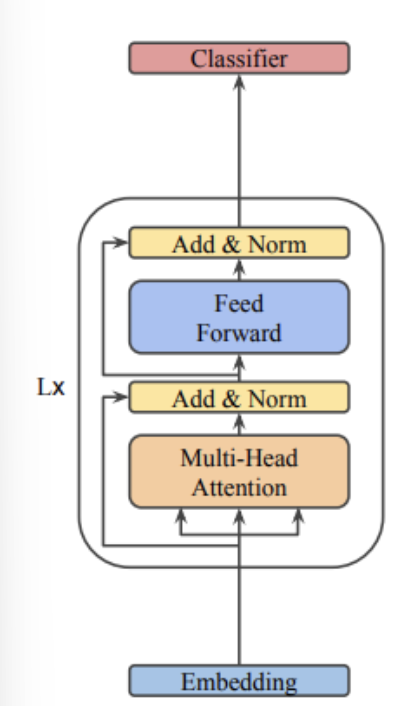

Referensi: https://tungmphung.com/a-review-of-pre-trained-language-models-from-bert-roberta-to-electra-deberta-bigbird-and-more/ 


In [26]:
model = RobertaClass()
model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [27]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=0.05)

Loss function menggunakan cross entropy loss untuk output multiclass. Sedangkan optimizernya menggunakan adam dengan learning rate 0.05. Training yang dilakukan oleh roberta akan jauh lebih lama dibandingkan dengan model BERT dan dipretarining dengan MLM task (15% teks acak akan dipilih untuk dimask, 80%diganti dengan mask dan 10% diganti dengan token random dari alfabet, dan sisanya tetap sama. Tujuannya adalah untuk mengembalikan teks asli dari versi masked) saja tanpa NSP task (mengambil dua teks A dan B, kemudian memprediksi apakah B merupakan kalimat setelah A di corpus. Tujuannya untuk memperkuat kemampuan BERT untuk memperjelas kalimat yang akan membantu task seperti Natural Language Inference).

In [28]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [29]:
from tqdm import tqdm
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(train_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5 iterations: {loss_step}")
            print(f"Training Accuracy per 5 iterations: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [30]:
EPOCHS = 1
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5 iterations: 1.1430641412734985
Training Accuracy per 5 iterations: 12.5


5it [05:53, 66.71s/it]

Training Loss per 5 iterations: 89.14785569906235
Training Accuracy per 5 iterations: 55.729166666666664


10it [12:46, 81.61s/it]

Training Loss per 5 iterations: 64.26734058423476
Training Accuracy per 5 iterations: 53.125


15it [24:39, 122.60s/it]

Training Loss per 5 iterations: 48.88233498483896
Training Accuracy per 5 iterations: 59.375


20it [29:31, 69.36s/it]

Training Loss per 5 iterations: 43.677998951503206
Training Accuracy per 5 iterations: 56.845238095238095


25it [34:23, 59.98s/it]

Training Loss per 5 iterations: 36.3187989455003
Training Accuracy per 5 iterations: 55.88942307692308


30it [39:29, 62.35s/it]

Training Loss per 5 iterations: 31.249038865489343
Training Accuracy per 5 iterations: 58.36693548387097


35it [44:28, 59.47s/it]

Training Loss per 5 iterations: 27.170463992489708
Training Accuracy per 5 iterations: 57.204861111111114


40it [49:18, 58.14s/it]

Training Loss per 5 iterations: 23.96173068662969
Training Accuracy per 5 iterations: 58.765243902439025


45it [54:02, 56.52s/it]

Training Loss per 5 iterations: 21.465275781310122
Training Accuracy per 5 iterations: 59.71467391304348


50it [58:30, 53.55s/it]

Training Loss per 5 iterations: 19.44164145226572
Training Accuracy per 5 iterations: 62.07107843137255


55it [1:02:51, 52.49s/it]

Training Loss per 5 iterations: 17.782347644014017
Training Accuracy per 5 iterations: 62.890625


60it [1:07:21, 54.12s/it]

Training Loss per 5 iterations: 16.39348836902712
Training Accuracy per 5 iterations: 63.47336065573771


65it [1:12:01, 55.84s/it]

Training Loss per 5 iterations: 15.215452189698365
Training Accuracy per 5 iterations: 63.82575757575758


70it [1:16:48, 57.99s/it]

Training Loss per 5 iterations: 14.184667073505025
Training Accuracy per 5 iterations: 65.40492957746478


75it [1:21:30, 56.77s/it]

Training Loss per 5 iterations: 13.305190987492862
Training Accuracy per 5 iterations: 65.74835526315789


80it [1:26:12, 56.55s/it]

Training Loss per 5 iterations: 12.526224942854894
Training Accuracy per 5 iterations: 66.51234567901234


85it [1:30:53, 56.24s/it]

Training Loss per 5 iterations: 11.835789487805478
Training Accuracy per 5 iterations: 67.26017441860465


90it [1:35:38, 57.03s/it]

Training Loss per 5 iterations: 11.228755884118133
Training Accuracy per 5 iterations: 67.54807692307692


95it [1:40:23, 56.89s/it]

Training Loss per 5 iterations: 10.685667579372724
Training Accuracy per 5 iterations: 67.74088541666667


100it [1:45:05, 56.32s/it]

Training Loss per 5 iterations: 10.194541186979501
Training Accuracy per 5 iterations: 68.03836633663366


105it [1:49:34, 53.66s/it]

Training Loss per 5 iterations: 9.745555717990083
Training Accuracy per 5 iterations: 68.51415094339623


110it [1:53:54, 52.31s/it]

Training Loss per 5 iterations: 9.338553274536991
Training Accuracy per 5 iterations: 68.86261261261261


115it [1:58:12, 51.69s/it]

Training Loss per 5 iterations: 8.971962110235774
Training Accuracy per 5 iterations: 68.88469827586206


120it [2:02:30, 51.52s/it]

Training Loss per 5 iterations: 8.62966632005597
Training Accuracy per 5 iterations: 69.24070247933884


125it [2:06:49, 51.74s/it]

Training Loss per 5 iterations: 8.313630839898472
Training Accuracy per 5 iterations: 69.61805555555556


130it [2:11:07, 51.56s/it]

Training Loss per 5 iterations: 8.024296171110095
Training Accuracy per 5 iterations: 69.82347328244275


135it [2:15:27, 51.96s/it]

Training Loss per 5 iterations: 7.756300273406155
Training Accuracy per 5 iterations: 70.03676470588235


140it [2:19:45, 51.71s/it]

Training Loss per 5 iterations: 7.505185740425231
Training Accuracy per 5 iterations: 70.32358156028369


145it [2:24:03, 51.58s/it]

Training Loss per 5 iterations: 7.276402220129967
Training Accuracy per 5 iterations: 70.33390410958904


150it [2:28:22, 51.86s/it]

Training Loss per 5 iterations: 7.0596421031367695
Training Accuracy per 5 iterations: 70.48841059602648


155it [2:32:40, 51.60s/it]

Training Loss per 5 iterations: 6.853523927048231
Training Accuracy per 5 iterations: 70.81330128205128


160it [2:36:59, 51.90s/it]

Training Loss per 5 iterations: 6.664339794690565
Training Accuracy per 5 iterations: 70.90450310559007


165it [2:41:17, 51.71s/it]

Training Loss per 5 iterations: 6.48877039641501
Training Accuracy per 5 iterations: 70.85843373493977


170it [2:45:35, 51.51s/it]

Training Loss per 5 iterations: 6.318892839359261
Training Accuracy per 5 iterations: 71.07090643274854


175it [2:49:54, 51.88s/it]

Training Loss per 5 iterations: 6.159911841492761
Training Accuracy per 5 iterations: 71.2002840909091


180it [2:54:12, 51.67s/it]

Training Loss per 5 iterations: 6.009714701228379
Training Accuracy per 5 iterations: 71.3225138121547


185it [2:58:30, 51.43s/it]

Training Loss per 5 iterations: 5.8641641159211435
Training Accuracy per 5 iterations: 71.62298387096774


190it [3:02:49, 51.94s/it]

Training Loss per 5 iterations: 5.732788847379036
Training Accuracy per 5 iterations: 71.56413612565446


195it [3:07:08, 51.62s/it]

Training Loss per 5 iterations: 5.606946247268696
Training Accuracy per 5 iterations: 71.5561224489796


200it [3:11:27, 51.98s/it]

Training Loss per 5 iterations: 5.485760673806442
Training Accuracy per 5 iterations: 71.62624378109453


205it [3:15:45, 51.83s/it]

Training Loss per 5 iterations: 5.369486559218573
Training Accuracy per 5 iterations: 71.73847087378641


210it [3:20:03, 51.55s/it]

Training Loss per 5 iterations: 5.259904407635684
Training Accuracy per 5 iterations: 71.80094786729858


215it [3:24:22, 52.00s/it]

Training Loss per 5 iterations: 5.1563103015500085
Training Accuracy per 5 iterations: 71.80266203703704


220it [3:28:40, 51.66s/it]

Training Loss per 5 iterations: 5.0562054216861725
Training Accuracy per 5 iterations: 71.90328054298642


225it [3:32:57, 51.49s/it]

Training Loss per 5 iterations: 4.961123874889011
Training Accuracy per 5 iterations: 71.9441371681416


230it [3:37:17, 51.87s/it]

Training Loss per 5 iterations: 4.8728672220851434
Training Accuracy per 5 iterations: 71.82088744588745


235it [3:41:35, 51.68s/it]

Training Loss per 5 iterations: 4.7853205508347285
Training Accuracy per 5 iterations: 71.875


240it [3:45:52, 51.44s/it]

Training Loss per 5 iterations: 4.702599140494691
Training Accuracy per 5 iterations: 71.875


245it [3:50:11, 51.83s/it]

Training Loss per 5 iterations: 4.621525862716077
Training Accuracy per 5 iterations: 71.97662601626017


250it [3:54:29, 51.70s/it]

Training Loss per 5 iterations: 4.543837689189797
Training Accuracy per 5 iterations: 72.04930278884463


255it [3:58:53, 52.95s/it]

Training Loss per 5 iterations: 4.46857060759794
Training Accuracy per 5 iterations: 72.15576171875


260it [4:03:26, 54.22s/it]

Training Loss per 5 iterations: 4.396408803275719
Training Accuracy per 5 iterations: 72.24616858237547


265it [4:07:47, 52.44s/it]

Training Loss per 5 iterations: 4.326704934463465
Training Accuracy per 5 iterations: 72.34492481203007


270it [4:12:09, 52.69s/it]

Training Loss per 5 iterations: 4.26131720285574
Training Accuracy per 5 iterations: 72.34778597785977


275it [4:16:30, 52.27s/it]

Training Loss per 5 iterations: 4.1991932760330215
Training Accuracy per 5 iterations: 72.3052536231884


280it [4:20:54, 52.91s/it]

Training Loss per 5 iterations: 4.138212162722897
Training Accuracy per 5 iterations: 72.31983985765125


285it [4:25:22, 53.99s/it]

Training Loss per 5 iterations: 4.078877102349188
Training Accuracy per 5 iterations: 72.35576923076923


290it [4:29:47, 52.76s/it]

Training Loss per 5 iterations: 4.019427683242817
Training Accuracy per 5 iterations: 72.51932989690722


295it [4:34:12, 53.07s/it]

Training Loss per 5 iterations: 3.962610468570445
Training Accuracy per 5 iterations: 72.63513513513513


300it [4:38:46, 54.61s/it]

Training Loss per 5 iterations: 3.9092144662161603
Training Accuracy per 5 iterations: 72.6640365448505


305it [4:43:09, 52.53s/it]

Training Loss per 5 iterations: 3.858924884324759
Training Accuracy per 5 iterations: 72.62050653594771


310it [4:47:29, 52.18s/it]

Training Loss per 5 iterations: 3.809041060914564
Training Accuracy per 5 iterations: 72.63866559485531


315it [4:51:48, 51.97s/it]

Training Loss per 5 iterations: 3.7622972367496432
Training Accuracy per 5 iterations: 72.56724683544304


320it [4:56:18, 53.37s/it]

Training Loss per 5 iterations: 3.7150880368513484
Training Accuracy per 5 iterations: 72.60514018691589


325it [5:00:46, 53.51s/it]

Training Loss per 5 iterations: 3.6692965967706375
Training Accuracy per 5 iterations: 72.64187116564418


330it [5:05:17, 54.01s/it]

Training Loss per 5 iterations: 3.6252872521603576
Training Accuracy per 5 iterations: 72.65861027190333


335it [5:09:51, 54.49s/it]

Training Loss per 5 iterations: 3.581983177523528
Training Accuracy per 5 iterations: 72.72135416666667


340it [5:14:23, 53.85s/it]

Training Loss per 5 iterations: 3.5411922895838437
Training Accuracy per 5 iterations: 72.68145161290323


345it [5:18:50, 53.85s/it]

Training Loss per 5 iterations: 3.501492280233113
Training Accuracy per 5 iterations: 72.66979768786128


350it [5:23:22, 54.06s/it]

Training Loss per 5 iterations: 3.4610713729661415
Training Accuracy per 5 iterations: 72.74750712250712


355it [5:27:51, 54.03s/it]

Training Loss per 5 iterations: 3.4242239071244605
Training Accuracy per 5 iterations: 72.70014044943821


360it [5:32:17, 53.77s/it]

Training Loss per 5 iterations: 3.3874902129998827
Training Accuracy per 5 iterations: 72.68871191135734


365it [5:36:44, 53.00s/it]

Training Loss per 5 iterations: 3.352260255178467
Training Accuracy per 5 iterations: 72.65198087431693


370it [5:41:03, 51.94s/it]

Training Loss per 5 iterations: 3.318299460362874
Training Accuracy per 5 iterations: 72.61522876920479


371it [5:41:14, 55.19s/it]

The Total Accuracy for Epoch 0: 72.61522876920479
Training Loss Epoch: 3.318299460362874
Training Accuracy Epoch: 72.61522876920479


Ada sekitar 11 ribu data untuk train, dan ada setiap batch ada 32, maka iterasi akan terjadi selama 11rb/32 = 371 iterasi. Pada setiap iterasi, loss berkurang untuk setiap iterasi. Loss sendiri merupakan kemampuan model untuk meyakinkan dirinya benar. Semakin berkurang nilai loss, maka semakin akurat juga hasilnya. Akurasi model juga semakin baik.

# Prediction

Evaluasi model akan dilakukan dengan menggunakan data test yang ada di test_loader. Untuk setiap nilai prediksi dan aktual akan disimpan di setiap iterasinya.

In [31]:
prdcts = []
actual = []

def Validation(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(test_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)
            prdcts.append(big_idx)
            actual.append(targets)
            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%10==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 10 iterations: {loss_step}")
                print(f"Validation Accuracy per 10 iterations: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu

In [32]:
acc = Validation(model, test_loader)
print("Accuracy on test data = %0.2f%%" % acc)

1it [00:08,  8.50s/it]

Validation Loss per 10 iterations: 0.8335167169570923
Validation Accuracy per 10 iterations: 68.75


11it [01:34,  8.69s/it]

Validation Loss per 10 iterations: 0.8105413480238481
Validation Accuracy per 10 iterations: 70.45454545454545


21it [03:10,  9.01s/it]

Validation Loss per 10 iterations: 0.8014241556326548
Validation Accuracy per 10 iterations: 71.13095238095238


31it [04:37,  8.83s/it]

Validation Loss per 10 iterations: 0.7728498145457237
Validation Accuracy per 10 iterations: 72.58064516129032


41it [06:03,  8.53s/it]

Validation Loss per 10 iterations: 0.7979201390975859
Validation Accuracy per 10 iterations: 70.88414634146342


51it [07:29,  8.51s/it]

Validation Loss per 10 iterations: 0.7863223885788637
Validation Accuracy per 10 iterations: 71.69117647058823


61it [08:56,  8.61s/it]

Validation Loss per 10 iterations: 0.7763390067170878
Validation Accuracy per 10 iterations: 72.43852459016394


71it [10:21,  8.58s/it]

Validation Loss per 10 iterations: 0.76847438871021
Validation Accuracy per 10 iterations: 73.06338028169014


81it [11:49,  8.81s/it]

Validation Loss per 10 iterations: 0.7740729123721888
Validation Accuracy per 10 iterations: 72.8395061728395


91it [13:14,  8.60s/it]

Validation Loss per 10 iterations: 0.7739686137372321
Validation Accuracy per 10 iterations: 72.93956043956044


101it [14:40,  8.60s/it]

Validation Loss per 10 iterations: 0.7734735050413868
Validation Accuracy per 10 iterations: 72.89603960396039


111it [16:08,  8.62s/it]

Validation Loss per 10 iterations: 0.7717369153155936
Validation Accuracy per 10 iterations: 73.02927927927928


121it [17:33,  8.55s/it]

Validation Loss per 10 iterations: 0.7650703568596485
Validation Accuracy per 10 iterations: 73.39876033057851


131it [19:00,  8.65s/it]

Validation Loss per 10 iterations: 0.7563148297881352
Validation Accuracy per 10 iterations: 73.9026717557252


141it [20:26,  8.57s/it]

Validation Loss per 10 iterations: 0.7556216406061295
Validation Accuracy per 10 iterations: 73.84751773049645


151it [21:53,  8.94s/it]

Validation Loss per 10 iterations: 0.7543681366554159
Validation Accuracy per 10 iterations: 73.88245033112582


161it [23:19,  8.65s/it]

Validation Loss per 10 iterations: 0.7510889824132742
Validation Accuracy per 10 iterations: 74.10714285714286


171it [24:44,  8.54s/it]

Validation Loss per 10 iterations: 0.7513539672595019
Validation Accuracy per 10 iterations: 74.08625730994152


181it [26:11,  8.60s/it]

Validation Loss per 10 iterations: 0.7524419179937457
Validation Accuracy per 10 iterations: 74.03314917127072


186it [26:46,  8.64s/it]

Validation Loss Epoch: 0.7536037955232846
Validation Accuracy Epoch: 74.03781228899392
Accuracy on test data = 74.04%


In [33]:
predict = np.concatenate(prdcts)
act = np.concatenate(actual)

Setiap hasil prediksi dan aktual yang sudah didapatkan akan berbentuk multidimensional array berbentuk tensor dengan ukuran yang bisa saja timpang di akhir sesuai dengan ukuran batch. Oleh karena itu untuk mendapatkan nilai evaluasi, akan diubah menjadi array satu dimensi dengan function concatenate.

In [34]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(act,predict, target_names=['NEGATIVE', 'NEUTRAL', 'POSITIVE']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    NEGATIVE       0.00      0.00      0.00       451
     NEUTRAL       0.00      0.00      0.00       318
    POSITIVE       0.74      1.00      0.85      2193

    accuracy                           0.74      2962
   macro avg       0.25      0.33      0.28      2962
weighted avg       0.55      0.74      0.63      2962



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Precision merupakan ukuran seberapa banyak prediksi positif yang dibenar (true positive)
- Recall merupakan seberapa banyak kasus positif yang benar diprediksi
- F1 score merupakan kombinasi dari precision dan recall
- support merupakan jumlah kemunculan setiap label yang benar

Referensi: https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec

Nilai yang akan dilihat adalah akurasi pada f1-score dengan nilai 74%. Sehingga dari test data tadi, model bisa memprediksi 74% data dengan benar. Pada saat training, nilai loss yang semakin berkurang juga menunjukkan bahwa training berhasil menghasilkan model yang lebih baik. Kedepannya jika memungkinkan, akan dicoba untuk membuat dan menguji model roberta dengan keseluruhan dataset. Saat ini saya mohon maaf untuk keterbatasan saya dalam membuat model ini.